## China & Japan Forecast

In [27]:
# Import libraries
import numpy as np 
import pandas as pd 
import seaborn as sns

import statsmodels.api as sm
from statsmodels.tsa.api import VAR
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.stats.stattools import durbin_watson
from statsmodels.tools.eval_measures import rmse, aic

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

import warnings
warnings.filterwarnings("ignore")

In [28]:
# Define key functions

# De-difference forecasted results
def invert_transformation(df_train, df_forecast):
    df_fc = df_forecast.copy()
    cols = df_train.columns
    for col in cols:        
        df_fc[str(col)+'_forecast'] = df_train[col].iloc[-1] + df_fc[str(col)+'_1d'].cumsum()
    return df_fc

In [29]:
def generate_forecast(df, iron_ore_up, hcc_up, scrap_up, export_perc_up, fai_up, iron_ore_down, hcc_down, scrap_down, export_perc_down, fai_down, months_ahead):
    df.set_index('Date', inplace=True)
    df.index = pd.to_datetime(df.index)
    
    '''VAR MODEL'''
    # After feature selection, these are the shortlisted variables
    list_of_variables = ['Iron Ore (CFR, $/t)', 'HCC (Aus FOB, $/t)',
        'Domestic Scrap (DDP Jiangsu incl. VAT $/t)',
        'Monthly Export of Semis & Finished Steel as % of Production',
        'FAI in urban real estate development (y-o-y) Growth',
        'Automobile Production (y-o-y)', 'Civil Metal-Vessels/Steel Ships (y-o-y)',
        'Household Fridges (y-o-y)', 'Air Conditioner (y-o-y)']
    hrc = ['HRC (FOB, $/t)']
    final_cols = hrc + list_of_variables
    final_df = df.copy()
    final_df = final_df[final_cols]

    # Split dataset into train and test set
    final_df_train, final_df_test = np.split(final_df,[int(0.925*len(final_df))])

    # Difference data to achieve stationarity
    final_df_train_differenced = final_df_train.diff().dropna()

    # Determine the best number of lags
    var_model = VAR(final_df_train_differenced)
    x = var_model.select_order(maxlags=12)

    # Fit model with optimal lag
    model_fitted = var_model.fit(4)

    # Using the last _ observations (since lag order is _) to forecast the following periods
    lag_order = model_fitted.k_ar
    forecast_input = final_df_train_differenced.values[-lag_order:]

    # Forecast the following periods
    forecast_length = len(final_df_test) + months_ahead
    fc = model_fitted.forecast(y=forecast_input, steps=forecast_length)
    fc_period = pd.date_range(start=final_df_test.index[0], periods=forecast_length, freq='MS')
    df_forecast = pd.DataFrame(fc, index=fc_period, columns=final_df_test.columns + '_1d')
    df_forecast.index.name = 'Date'

    # De-difference forecasted results
    df_forecast_processed = invert_transformation(final_df_train, df_forecast)

    # Split forecast into testset's forecast and the actual forecast
    df_forecast_testset, df_forecast_actual = df_forecast_processed[0:-months_ahead], df_forecast_processed[-months_ahead:]


    '''MULTIPLE LINEAR REGRESSION MODEL'''
    # Define x and y variables
    X = df[list_of_variables]
    y = df['HRC (FOB, $/t)']

    # Split into train and test sets
    X_train, X_test = np.split(X,[int(0.925*len(X))])
    y_train, y_test = np.split(y,[int(0.925*len(y))])

    # Scale x variables since they are of different magnitudes
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Model fitting
    lr_model = LinearRegression()
    lr_model.fit(X_train_scaled, y_train)

    # Reading var predictions for X variables
    forecasted_X = df_forecast_actual[['Iron Ore (CFR, $/t)_forecast', 'HCC (Aus FOB, $/t)_forecast',
         'Domestic Scrap (DDP Jiangsu incl. VAT $/t)_forecast',
         'Monthly Export of Semis & Finished Steel as % of Production_forecast',
         'FAI in urban real estate development (y-o-y) Growth_forecast',
         'Automobile Production (y-o-y)_forecast', 'Civil Metal-Vessels/Steel Ships (y-o-y)_forecast',
         'Household Fridges (y-o-y)_forecast', 'Air Conditioner (y-o-y)_forecast']].copy()
    
    # Scale var predictions
    forecasted_X.rename(columns={'Iron Ore (CFR, $/t)_forecast':'Iron Ore (CFR, $/t)', 'HCC (Aus FOB, $/t)_forecast':'HCC (Aus FOB, $/t)',
         'Domestic Scrap (DDP Jiangsu incl. VAT $/t)_forecast':'Domestic Scrap (DDP Jiangsu incl. VAT $/t)',
         'Monthly Export of Semis & Finished Steel as % of Production_forecast':'Monthly Export of Semis & Finished Steel as % of Production',
         'FAI in urban real estate development (y-o-y) Growth_forecast':'FAI in urban real estate development (y-o-y) Growth',
         'Automobile Production (y-o-y)_forecast':'Automobile Production (y-o-y)', 'Civil Metal-Vessels/Steel Ships (y-o-y)_forecast':'Civil Metal-Vessels/Steel Ships (y-o-y)',
         'Household Fridges (y-o-y)_forecast':'Household Fridges (y-o-y)', 'Air Conditioner (y-o-y)_forecast':'Air Conditioner (y-o-y)'}, inplace=True)
    forecasted_X_scaled = scaler.transform(forecasted_X)

    # Obtain y forecast
    y_forecast = lr_model.predict(forecasted_X_scaled)
    y_forecast_new = np.insert(y_forecast, 0, df['HRC (FOB, $/t)'][-1])

    forecast_period = pd.date_range(start=df.index[-1], periods=months_ahead+1, freq='MS')
    final_forecast = pd.DataFrame(y_forecast_new, index=forecast_period, columns=['HRC (FOB, $/t)_f'])
    final_forecast.index.name = 'Date'

    # Def code for creating the forecast region
    def create_forecast_region(iron_ore, hcc, scrap, export_perc, fai, var_forecast):
          fc_p = pd.date_range(start=var_forecast.index[0], end=var_forecast.index[-1], freq='MS')
          up_down_df = pd.DataFrame(np.nan, index=fc_p, columns=['Iron Ore (CFR, $/t)',
                                                                 'HCC (Aus FOB, $/t)',
                                                                 'Domestic Scrap (DDP Jiangsu incl. VAT $/t)',
                                                                 'Monthly Export of Semis & Finished Steel as % of Production',
                                                                 'FAI in urban real estate development (y-o-y) Growth',
                                                                 'Automobile Production (y-o-y)', 'Civil Metal-Vessels/Steel Ships (y-o-y)',
                                                                 'Household Fridges (y-o-y)', 'Air Conditioner (y-o-y)'])
          up_down_df.index.name = 'Date'
          up_down_df['Iron Ore (CFR, $/t)'] = iron_ore
          up_down_df['HCC (Aus FOB, $/t)'] = hcc
          up_down_df['Domestic Scrap (DDP Jiangsu incl. VAT $/t)'] = scrap
          up_down_df['Monthly Export of Semis & Finished Steel as % of Production'] = export_perc
          up_down_df['FAI in urban real estate development (y-o-y) Growth'] = fai
          up_down_df['Automobile Production (y-o-y)'] = var_forecast['Automobile Production (y-o-y)_forecast']
          up_down_df['Civil Metal-Vessels/Steel Ships (y-o-y)'] = var_forecast['Civil Metal-Vessels/Steel Ships (y-o-y)_forecast']
          up_down_df['Household Fridges (y-o-y)'] = var_forecast['Household Fridges (y-o-y)_forecast']
          up_down_df['Air Conditioner (y-o-y)'] = var_forecast['Air Conditioner (y-o-y)_forecast']

          up_down_scaled = scaler.transform(up_down_df)

          up_down_f = lr_model.predict(up_down_scaled)
          up_down_f_new = np.insert(up_down_f, 0, df['HRC (FOB, $/t)'][-1])

          fc_dates = pd.date_range(start=df.index[-1], periods=months_ahead+1, freq='MS')
          up_down_forecast = pd.DataFrame(up_down_f_new, index=fc_dates, columns=['HRC (FOB, $/t)'])
          up_down_forecast.index.name = 'Date'
          return up_down_forecast
    
    # Forecasting y upside and downside
    df_forecast_upside = create_forecast_region(iron_ore_up, hcc_up, scrap_up, export_perc_up, fai_up, df_forecast_actual)
    df_forecast_downside = create_forecast_region(iron_ore_down, hcc_down, scrap_down, export_perc_down, fai_down, df_forecast_actual)
    
    # Plot forecast
    fig, ax = plt.subplots(figsize=(12, 6))
    df['HRC (FOB, $/t)'].plot(color='k')
    final_forecast['HRC (FOB, $/t)_f'].plot(color='r', linestyle ='dashed', label='LR Forecast')
    ax.fill_between(x=forecast_period, y1=df_forecast_downside['HRC (FOB, $/t)'], y2=df_forecast_upside['HRC (FOB, $/t)'], alpha=0.2)
    
    plt.title("Forecasting of China's HRC prices using the Regression model")
    plt.ylabel("HRC (FOB, $/t)")
    plt.xlabel("Date")
    plt.axvline(x = df.index[-1], color = 'forestgreen', linestyle = 'dotted')
    ax.legend()

In [30]:
# Read csv
file_path = '../data/final/wo_na.csv'
df = pd.read_csv(file_path)

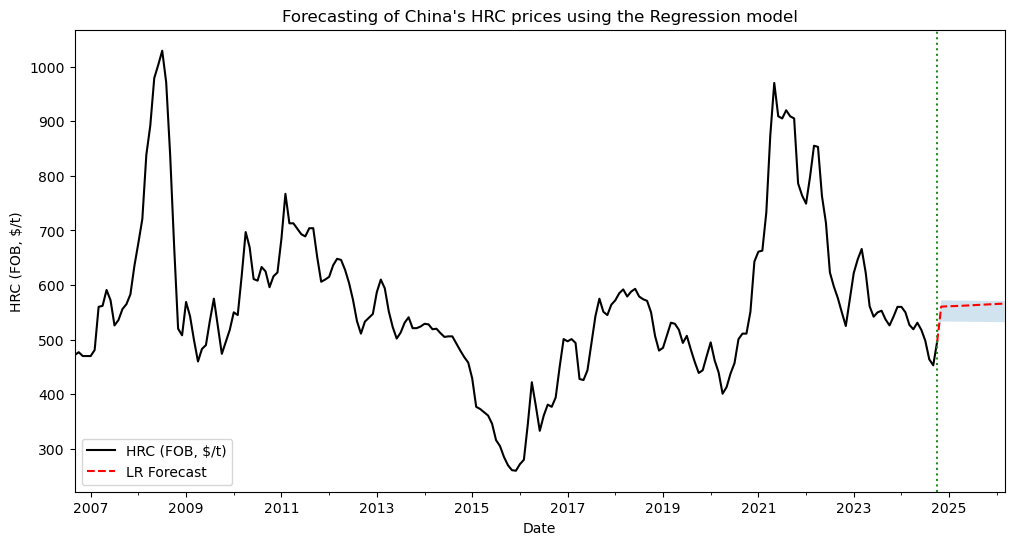

In [31]:
generate_forecast(df, 100, 220, 400, 9, 5, 85, 180, 350, 12, 1, 17)